In [20]:
import os
import torch
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import memory_profiler
import torch.optim as optim
import time


In [21]:

class Alzheimer_Dataset(Dataset):
    """ Defines a dataset loader for our customized brain scane dataset.
    """
    
    def __init__(self,csv_file: list, root_dir: list, transform=None):
        super().__init__()
        # stores the location of csv_file and the image directory path (root_dir)
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    
    def __getitem__(self, index):
        """ Defines a method for retrieving a instance of data defined by a given index"""
        imag_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(imag_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
        
        return (image, y_label)
    
    def __len__(self):
        """ defines a method of getting the amount of data."""
        return len(self.annotations)

In [22]:
def imshow(img):
    """ Displays the images """
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [23]:
class CNN(torch.nn.Module):
    """ Defines a Convolutional Neural Network architecture.
        Initializes a convolutional neural network with 2 convolutional layers each followed by an activation 
        function and a pooling layer. Finishing with a layer that flattens our data and uses the falttened data
        to map to our output layer.
    """
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Flatten(),
            torch.nn.Linear(4576, 4),
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [24]:
# Defines the path to the training 
csv_file_path = "data.csv"

# image directory paths
root_dir = "data"


# Hyperparameters
batch_size = 32
epoch = 3
learning_rate = 0.001
momentum = 0.9

# sets the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [25]:
# Loading dataset
dataset = Alzheimer_Dataset(csv_file=csv_file_path, root_dir=root_dir, transform = transforms.ToTensor())


train_set, test_set = torch.utils.data.random_split(dataset, [5122, 1278]) # splits 5121 items to be training set and splits 1278 items to be test set 
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, drop_last=False)

classes = ("Non Demented", "Very Mildly Demented", "Mildly Demented", "Moderate Demented")

In [27]:

net = CNN().to(device)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Defines the backward propagation of the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


print(f"Memory consumed: {memory_profiler.memory_usage()[0] - mem:.0f} mb")
print(f"       # of batches: {len(train_loader)}")
print(f"    Image data type: {type(images)}")
print(f"   Image batch size: {images.shape}")  # dimensions are (batch size, image channels, image height, image width)
print(f"  Target batch size: {labels.shape}")
print(f"       Batch memory: {memory_profiler.memory_usage()[0] - mem:.2f} mb")  # memory usage after loading batch

# show images
imshow(torchvision.utils.make_grid(images))


In [ ]:
# Training the model.
for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')




In [34]:
# Saving the model

PATH = './Alheimer_cnnet.pth'
# torch.save(net.state_dict(), PATH)

GroundTruth:  Non Demented, Very Mildly Demented, Very Mildly Demented, Non Demented


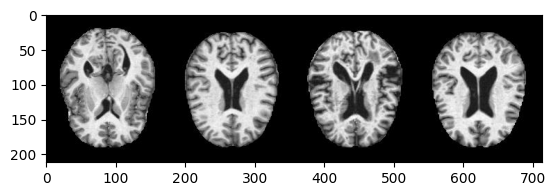

Predicted:  Non Demented, Non Demented, Non Demented, Non Demented


In [37]:
# Testing one case with the model

ataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
print('GroundTruth: ', ', '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
imshow(torchvision.utils.make_grid(images[0:4]))


net = CNN()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ', '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [39]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        # print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
        # print('Predicted: ', ' '.join(f'{classes[predictions[j]]:5s}' for j in range(4)))

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} % With correct count: {correct_count}, total_pred: {total_pred[classname]}')


Accuracy for class: Non Demented is 90.9 % With correct count: 611, total_pred: 672
Accuracy for class: Very Mildly Demented is 22.2 % With correct count: 95, total_pred: 428
Accuracy for class: Mildly Demented is 0.0 % With correct count: 0, total_pred: 168
Accuracy for class: Moderate Demented is 0.0 % With correct count: 0, total_pred: 10
